# Chapter 8. Making Transformers Efficient in Production

## Intent Detection as a Case Study

In [1]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt, device=-1)

/home/ssanchez/env/transformers/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/ssanchez/env/transformers/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feed

In [13]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490031242370605}]

## Creating a Performance Benchmark

*Model performance*
How well does our model perform on a well-crafted test set that reflects production data?

*Latency*
How fast can our model deliver predictions?

*Memory*
Billion-parameter models. Especially important role in mobile or edge devices.

In [5]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT-baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        pass

    def compute_size(self):
        pass

    def time_pipeline(self):
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [6]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

In [7]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [8]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [9]:
import evaluate

accuracy_score = evaluate.load("accuracy")

In [10]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [11]:
import torch
from pathlib import Path

def compute_size(self):
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate the size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [14]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 44.783
Latency (ms) - 42.351
Latency (ms) - 41.972


In [15]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    latencies = []
    for _ in range(10):
        _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [27]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 255.88
Average latency (ms) - 19.66 +\- 0.51
Accuracy on test set - 0.883


## Making Models Smaller via Knowledge Distillation

training a smaller *student* model to mimic the behavior of a slower, larger, but better-performing *teacher*.

### Knowledge Distillation for Fine-tuning

For supervised tasks like fine-tuning, the main idea is to augment the ground truth labels with a distribution of "soft probabilities" from the teacher which provide complementary information for the sudient to learn from.

### Knowledge Distillation for Pretraining

general-purpose student that can be subsequently fine-tuned on downstream tasks. The teacher is a pretrained language model ehich transfers its knowledge about masked language modleing to the student.

Let's see how we can use knowledge distillation to fine-tune a smaller and faster model. To do that we'll need a way to augment the corss-entropy loss with a Lkd term. Fortunately we can do this by **creating our own trainer**!

### Creating a Knowledge Distillation Trainer

We need to add a few things to the Trainer base class:
- The new hyperparameters alpha and T, which control the relative weight of the distillation loss and how much the probability distribution of the labels should be smoothed
- The fine-tuned teacher model, which in our casi is BERT-base
- A new loss function that combines the cross-entropy loss with the knowledge distillation loss

In [16]:
from transformers import TrainingArguments

# Adding the new hyperparameters. include them as attrbutes
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [17]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

# new loss function for the trainer itself. overriding compute_loss()
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs): # teacher model that has already been fine-tuned on our task
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # had to add **kwargs
        outputs_stu = model(**inputs)
        # Extract corss-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean") # we average the losses over the batch dimension
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1), # expects the inputs in the form of log probabilities
            F.softmax(logits_tea / self.args.temperature, dim=-1) # and the labels as normal probabilities
        )
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

### Choosing a Good Student Initialization

Which pretrained languange model should we pick for the student? In general we should pick a smaller model for the student to reduce the latency and memory footprint.

A good rule of thumb from the literature is that knowledge distillation works best when the teacher and student are of the same *model type*. Different model types can have different output embedding spaces, which hinders the ability of the sudent to mimic the teacher.

In our case the teacher is BERT, so DistilBERT is a natural candidate to initialize the student with since it has 40% fewer parameters and has been shown to acheve strong results on downstream tasks.

In [18]:
from transformers import AutoTokenizer

# Tokenize and encode our queries. Instantiate DistilBERT and create a simple tokenize_text() function ot take care of the preprocessing
student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"]) # we no longer need text column
clinc_enc = clinc_enc.rename_column("intent", "labels") # so it can be automatically detected by the trainer

In [16]:
from huggingface_hub import notebook_login
notebook_login()

In [19]:
# define compute_metrics() for our DistillationTrainer
def compute_metrics(pred):
    preds, labels = pred
    preds = np.argmax(preds, axis=1)
    return accuracy_score.compute(predictions=preds, references=labels)

In [20]:
# Define training argumemnts
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy="epoch",
    num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1,
    weight_decay=0.01, push_to_hub=True
)

/home/ssanchez/env/transformers/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
from transformers import AutoConfig
# initialize a student model

id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

num_labels = intents.num_classes
student_config = (AutoConfig.
                 from_pretrained(student_ckpt,
                                num_labels=num_labels,
                                id2label=id2label,
                                label2id=label2id))

In [22]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification.from_pretrained(student_ckpt, config=student_config).to(device))

In [23]:
# Load the teacher and fine-tune
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                .from_pretrained(teacher_ckpt,
                                num_labels=num_labels)
                .to(device))

distilbert_trainer = DistillationTrainer(model_init=student_init,
                                        teacher_model=teacher_model, args=student_training_args,
                                        train_dataset=clinc_enc["train"],
                                        eval_dataset=clinc_enc["validation"],
                                        compute_metrics=compute_metrics, tokenizer=student_tokenizer)

# distilbert_trainer.train()

/tmp/ipykernel_1523099/3053386859.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if p

The 92% accuracy on the validation set looks quite good compared to the 94% that the BERT-base teacher achieves.

In [22]:
distilbert_trainer.push_to_hub("Training completed!")

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/sergi24sanchez/distilbert-base-uncased-finetuned-clinc/commit/ce294051719361819bcacad60974dc2bf8f6c0a2', commit_message='Training completed!', commit_description='', oid='ce294051719361819bcacad60974dc2bf8f6c0a2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sergi24sanchez/distilbert-base-uncased-finetuned-clinc', endpoint='https://huggingface.co', repo_type='model', repo_id='sergi24sanchez/distilbert-base-uncased-finetuned-clinc'), pr_revision=None, pr_num=None)

In [24]:
finetuned_ckpt = "transformersbook/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt, device=-1)

In [47]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 16.00 +\- 0.07
Accuracy on test set - 0.883


To compare these results against our baseline, let's create a scatter plot of the accyracy against the latency, with the radius of each point corresponding to the size of the model on disk.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
            alpha=0.5, s=df_opt["size_mb"], label=idx, marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
            alpha=0.5, s=df_opt["size_mb"], label=idx)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT-baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()


/tmp/ipykernel_1523099/3513452108.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


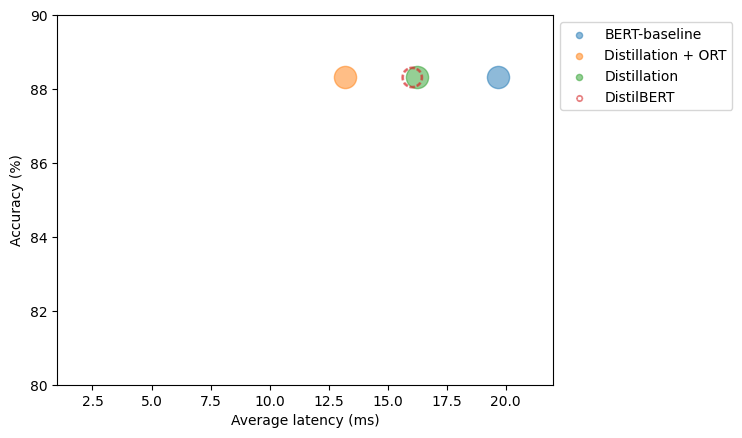

In [48]:
plot_metrics(perf_metrics, optim_type)

From the plot we can see that by using a smaller model we've managed to significantly decrease the average latency. And all this at the price of just 1% reduction in accuracy!

Let's see if we can close that last gap by including the distillation loss of the teacher and finding good values for alpha and T.

### Finding Good Hyperparameters with Optuna

To find good values of alpha and T we could do a grid search over the 2D parameter space. But a much better alternative is to *Optuna*, which is an optimization framework designed for just this type of task.

Optuna formulates the search problem in therms of an objesctive function that is oprimized though mutliple *trials*. We can dinf the minimum of $f(x,y)$ by defining an *objective()* function that returns the value of $f(x,y)$

In [24]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2) # suggest_float specifies the parameter ranges to sample uniformly from
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [ ]:
# Optuna collects multiple trials as a *study*, so to create one we just pass the *objective()* function to study.optimize()
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

In [26]:
study.best_params

{'x': 1.0028932345941632, 'y': 1.0079501096871013}

To use Optuna in Transformers, we use similar logic by first defining the hyperparameter space that we wish to optimize over.

In [27]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
           "alpha": trial.suggest_float("alpha", 0, 1),
           "temperature": trial.suggest_int("temperature", 2, 20)}

Running the hyperparameter search with the Trainer is then quite simple

In [30]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space
)

[I 2025-06-18 15:22:12,001] A new study created in memory with name: no-name-6d446f1f-3b0a-4877-8360-de79d9078864
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokeniz

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.201185,0.565806
2,0.315800,0.106367,0.799355
3,0.315800,0.076926,0.861613
4,0.122000,0.064741,0.875484
5,0.088100,0.060900,0.880645


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
[I 2025-06-18 15:24:57,619] Trial 0 finished with value: 0.8806451612903226 and parameters: {'num_train_epochs': 5, 'alpha': 0.33159369526218396, 'temperature': 17}. Best is trial 0 with value: 0.8806451612903226.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre

eval/accuracy,▁▆███
eval/loss,█▃▂▁▁
eval/runtime,▇▁██▁
eval/samples_per_second,▂█▁▁█
eval/steps_per_second,▂█▁▁█
train/epoch,▁▂▃▅▅▆███
train/global_step,▁▂▃▄▅▆███
train/grad_norm,█▆▁
train/learning_rate,█▄▁
train/loss,█▂▁
eval/accuracy,0.88065


wandb: Currently logged in as: sergi-sanchez-bonilla to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.201185,0.565806
2,0.315800,0.106367,0.799355
3,0.315800,0.076926,0.861613
4,0.122000,0.064741,0.875484
5,0.088100,0.060900,0.880645


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
[I 2025-06-18 15:26:51,167] Trial 1 finished with value: 0.8806451612903226 and parameters: {'num_train_epochs': 5, 'alpha': 0.7964592714435752, 'temperature': 17}. Best is trial 0 with value: 0.8806451612903226.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_

eval/accuracy,▁▆███
eval/loss,█▃▂▁▁
eval/runtime,▁▃▄▇█
eval/samples_per_second,█▆▅▂▁
eval/steps_per_second,█▆▅▂▁
train/epoch,▁▂▃▅▅▆███
train/global_step,▁▂▃▄▅▆███
train/grad_norm,█▆▁
train/learning_rate,█▄▁
train/loss,█▂▁
eval/accuracy,0.88065


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.191109,0.578710
2,0.307600,0.094603,0.823548
3,0.307600,0.063944,0.879032
4,0.109100,0.049479,0.893548
5,0.070000,0.040733,0.907419
6,0.070000,0.035880,0.914194
7,0.055500,0.033309,0.917742
8,0.048700,0.031520,0.922258
9,0.048700,0.030961,0.922903


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
[I 2025-06-18 15:30:12,207] Trial 2 finished with value: 0.9229032258064516 and parameters: {'num_train_epochs': 9, 'alpha': 0.004064108208858719, 'temperature': 19}. Best is trial 2 with value: 0.9229032

eval/accuracy,▁▆▇▇█████
eval/loss,█▄▂▂▁▁▁▁▁
eval/runtime,▁▂▃▅▂▃▃▃█
eval/samples_per_second,█▇▆▄▇▆▆▅▁
eval/steps_per_second,█▇▆▄▇▆▆▅▁
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇██
train/global_step,▁▂▂▃▃▄▄▄▅▆▆▇▇██
train/grad_norm,█▇▃▂▁
train/learning_rate,█▆▅▃▁
train/loss,█▃▂▁▁
eval/accuracy,0.9229


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.218571,0.606774
2,0.351900,0.101634,0.841613
3,0.351900,0.064961,0.885161
4,0.118200,0.048449,0.900323
5,0.071900,0.038829,0.913226
6,0.071900,0.033775,0.922903
7,0.055400,0.030789,0.925484
8,0.047600,0.028760,0.930000
9,0.047600,0.027682,0.930323
10,0.044000,0.027219,0.929677


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
[I 2025-06-18 15:33:41,330] Trial 3 finished with value: 0.9296774193548387 and parameters: {'num_train_epochs': 10, 'alpha': 0.7195121674709193, 'temperature': 6}. Best is trial 3 with value: 0.929677419

eval/accuracy,▁▆▇▇██████
eval/loss,█▄▂▂▁▁▁▁▁▁
eval/runtime,▁▁▁▂▂█▂▂▃▂
eval/samples_per_second,███▇▆▁▇▇▆▇
eval/steps_per_second,███▇▆▁▇▇▆▇
train/epoch,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/global_step,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/grad_norm,█▇▃▁▁▁
train/learning_rate,█▇▅▄▂▁
train/loss,█▃▂▁▁▁
eval/accuracy,0.92968


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.203056,0.594839
2,0.327700,0.097361,0.835161
3,0.327700,0.063957,0.884194
4,0.112900,0.048433,0.898387
5,0.070300,0.039128,0.911290
6,0.070300,0.034089,0.921290
7,0.054600,0.031127,0.922903
8,0.047100,0.029058,0.929032
9,0.047100,0.027952,0.928387
10,0.043500,0.027481,0.929032


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
[I 2025-06-18 15:38:42,221] Trial 4 finished with value: 0.9290322580645162 and parameters: {'num_train_epochs': 10, 'alpha': 0.3473496744950487, 'temperature': 9}. Best is trial 3 with value: 0.929677419

eval/accuracy,▁▆▇▇██████
eval/loss,█▄▂▂▁▁▁▁▁▁
eval/runtime,▁▂▂▃█▆▃▂▂▁
eval/samples_per_second,█▇▇▆▁▃▆▇▇█
eval/steps_per_second,█▇▇▆▁▃▆▇▇█
train/epoch,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/global_step,▁▁▂▃▃▃▄▄▅▅▆▆▆▇███
train/grad_norm,█▇▃▁▁▁
train/learning_rate,█▇▅▄▂▁
train/loss,█▃▂▁▁▁
eval/accuracy,0.92903


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.195350,0.574516


[I 2025-06-18 15:39:00,560] Trial 5 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.57452
eval/loss,0.19535
eval/runtime,1.3664
eval/samples_per_second,2268.688


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.257194,0.611935
2,0.404400,0.120026,0.834516
3,0.404400,0.077707,0.878065


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
[I 2025-06-18 15:39:56,411] Trial 6 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█
eval/loss,█▃▁
eval/runtime,▁▆█
eval/samples_per_second,█▃▁
eval/steps_per_second,█▃▁
train/epoch,▁▃▅█
train/global_step,▁▃▄█
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.87806


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.197249,0.585484
2,0.316500,0.097855,0.823871
3,0.316500,0.066231,0.877742


[I 2025-06-18 15:40:46,450] Trial 7 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█
eval/loss,█▃▁
eval/runtime,▁▁█
eval/samples_per_second,██▁
eval/steps_per_second,██▁
train/epoch,▁▃▅█
train/global_step,▁▃▄█
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.87774


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.230343,0.590000
2,0.359900,0.116848,0.817097


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
[I 2025-06-18 15:41:23,136] Trial 8 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/loss,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▅█
train/global_step,▁▅█
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.8171


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.194135,0.585806
2,0.313500,0.094662,0.828710
3,0.313500,0.063084,0.882258
4,0.109400,0.048224,0.894839
5,0.069100,0.039204,0.910645
6,0.069100,0.034241,0.918065


[I 2025-06-18 15:43:02,632] Trial 9 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇███
eval/loss,█▄▂▂▁▁
eval/runtime,▂▃▁█▆▇
eval/samples_per_second,▇▆█▁▃▂
eval/steps_per_second,▇▆█▁▃▂
train/epoch,▁▂▂▄▄▅▆▇█
train/global_step,▁▂▂▄▄▅▆▇█
train/grad_norm,█▇▁
train/learning_rate,█▅▁
train/loss,█▂▁
eval/accuracy,0.91806


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.209309,0.592258
2,0.335100,0.101523,0.831613
3,0.335100,0.067484,0.879032
4,0.117600,0.051797,0.894516
5,0.074900,0.042842,0.907097


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
[I 2025-06-18 15:44:31,070] Trial 10 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇██
eval/loss,█▃▂▁▁
eval/runtime,█▂▅▁▅
eval/samples_per_second,▁▇▄█▄
eval/steps_per_second,▁▇▄█▄
train/epoch,▁▂▃▅▅▆██
train/global_step,▁▂▃▄▅▆██
train/grad_norm,█▇▁
train/learning_rate,█▅▁
train/loss,█▂▁
eval/accuracy,0.9071


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.203056,0.594839
2,0.327700,0.097361,0.835161
3,0.327700,0.063957,0.884194
4,0.112900,0.048433,0.898387
5,0.070300,0.039128,0.911290
6,0.070300,0.034089,0.921290
7,0.054600,0.031127,0.922903
8,0.047100,0.029058,0.929032
9,0.047100,0.027952,0.928387
10,0.043500,0.027481,0.929032


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
[I 2025-06-18 15:47:56,956] Trial 11 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇▇██████
eval/loss,█▄▂▂▁▁▁▁▁▁
eval/runtime,▁▁▁▂▁█▄▄▂▂
eval/samples_per_second,███▇█▁▅▅▇▇
eval/steps_per_second,███▇█▁▅▅▇▇
train/epoch,▁▁▂▃▃▃▄▄▅▅▆▆▆▇██
train/global_step,▁▁▂▃▃▃▄▄▅▅▆▆▆▇██
train/grad_norm,█▇▃▁▁▁
train/learning_rate,█▇▅▄▂▁
train/loss,█▃▂▁▁▁
eval/accuracy,0.92903


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.408134,0.673226
2,0.642100,0.140798,0.842258
3,0.642100,0.072515,0.895161
4,0.164400,0.052278,0.914839
5,0.081800,0.043040,0.923871
6,0.081800,0.038619,0.928710
7,0.061900,0.035834,0.931290
8,0.054100,0.034226,0.933548
9,0.054100,0.033744,0.932903


[I 2025-06-18 15:51:27,476] Trial 12 finished with value: 0.9329032258064516 and parameters: {'num_train_epochs': 9, 'alpha': 0.7953492187921081, 'temperature': 2}. Best is trial 12 with value: 0.9329032258064516.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇▇█████
eval/loss,█▃▂▁▁▁▁▁▁
eval/runtime,▅▆█▆▄▆▃▃▁
eval/samples_per_second,▄▃▁▃▅▃▆▆█
eval/steps_per_second,▄▃▁▃▅▃▆▆█
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇██
train/global_step,▁▂▂▃▃▄▄▄▅▆▆▇▇██
train/grad_norm,█▅▂▁▁
train/learning_rate,█▆▅▃▁
train/loss,█▂▁▁▁
eval/accuracy,0.9329


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.408134,0.673226
2,0.642100,0.140798,0.842258
3,0.642100,0.072515,0.895161
4,0.164400,0.052278,0.914839
5,0.081800,0.043040,0.923871
6,0.081800,0.038619,0.928710
7,0.061900,0.035834,0.931290
8,0.054100,0.034226,0.933548
9,0.054100,0.033744,0.932903


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
[I 2025-06-18 15:57:19,021] Trial 13 finished with value: 0.9329032258064516 and parameters: {'num_train_epochs': 9, 'alpha': 0.8855233715103562, 'temperature': 2}. Best is trial 12 with value: 0.9329032258064516.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre

eval/accuracy,▁▆▇▇█████
eval/loss,█▃▂▁▁▁▁▁▁
eval/runtime,▁▄▇▇▇▇█▇▇
eval/samples_per_second,█▅▂▂▂▂▁▂▂
eval/steps_per_second,█▅▂▂▂▂▁▂▂
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇██
train/global_step,▁▂▂▃▃▄▄▄▅▆▆▇▇██
train/grad_norm,█▅▂▁▁
train/learning_rate,█▆▅▃▁
train/loss,█▂▁▁▁
eval/accuracy,0.9329


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.408134,0.673226
2,0.642100,0.140798,0.842258
3,0.642100,0.072515,0.895161
4,0.164400,0.052278,0.914839
5,0.081800,0.043040,0.923871
6,0.081800,0.038619,0.928710
7,0.061900,0.035834,0.931290
8,0.054100,0.034226,0.933548
9,0.054100,0.033744,0.932903


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
[I 2025-06-18 16:04:02,890] Trial 14 finished with value: 0.9329032258064516 and parameters: {'num_train_epochs': 9, 'alpha': 0.9495232964645796, 'temperature': 2}. Best is trial 12 with value: 0.9329032258064516.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre

eval/accuracy,▁▆▇▇█████
eval/loss,█▃▂▁▁▁▁▁▁
eval/runtime,▁▃▅▅▆▆▆█▆
eval/samples_per_second,█▆▄▄▃▃▃▁▃
eval/steps_per_second,█▆▄▄▃▃▃▁▃
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇██
train/global_step,▁▂▂▃▃▄▄▄▅▆▆▇▇██
train/grad_norm,█▅▂▁▁
train/learning_rate,█▆▅▃▁
train/loss,█▂▁▁▁
eval/accuracy,0.9329


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.408134,0.673226
2,0.642100,0.140798,0.842258
3,0.642100,0.072515,0.895161
4,0.164400,0.052278,0.914839
5,0.081800,0.043040,0.923871
6,0.081800,0.038619,0.928710
7,0.061900,0.035834,0.931290
8,0.054100,0.034226,0.933548
9,0.054100,0.033744,0.932903


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
[I 2025-06-18 16:11:44,786] Trial 15 finished with value: 0.9329032258064516 and parameters: {'num_train_epochs': 9, 'alpha': 0.8731309051569979, 'temperature': 2}. Best is trial 12 with value: 0.9329032258064516.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre

eval/accuracy,▁▆▇▇█████
eval/loss,█▃▂▁▁▁▁▁▁
eval/runtime,▅▁▃▃▅▆▆█▆
eval/samples_per_second,▄█▆▆▄▃▃▁▃
eval/steps_per_second,▄█▆▆▄▃▃▁▃
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇██
train/global_step,▁▂▂▃▃▄▄▄▅▆▆▇▇██
train/grad_norm,█▅▂▁▁
train/learning_rate,█▆▅▃▁
train/loss,█▂▁▁▁
eval/accuracy,0.9329


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.234402,0.609355
2,0.372300,0.110579,0.835161


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
[I 2025-06-18 16:12:26,897] Trial 16 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/loss,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▅█
train/global_step,▁▅█
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.83516


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.291499,0.639032
2,0.462400,0.121100,0.844516
3,0.462400,0.070976,0.888710
4,0.141600,0.051666,0.903226
5,0.080600,0.042065,0.917742
6,0.080600,0.037262,0.921935


[I 2025-06-18 16:14:05,363] Trial 17 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇███
eval/loss,█▃▂▁▁▁
eval/runtime,▁▁▆▇▇█
eval/samples_per_second,██▃▂▂▁
eval/steps_per_second,██▃▂▂▁
train/epoch,▁▂▂▄▄▅▆▇█
train/global_step,▁▂▂▄▄▅▆▇█
train/grad_norm,█▆▁
train/learning_rate,█▅▁
train/loss,█▂▁
eval/accuracy,0.92194


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.199541,0.587097


[I 2025-06-18 16:14:23,999] Trial 18 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.5871
eval/loss,0.19954
eval/runtime,1.3945
eval/samples_per_second,2223.019


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.212773,0.600000


[I 2025-06-18 16:14:44,168] Trial 19 pruned. 


In [31]:
print(best_run)

BestRun(run_id='12', objective=0.9329032258064516, hyperparameters={'num_train_epochs': 9, 'alpha': 0.7953492187921081, 'temperature': 2}, run_summary=None)


In [32]:
# Let's update our training arguments with these values and run the final training run
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

# define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
                                    teacher_model=teacher_model, args=student_training_args,
                                    train_dataset=clinc_enc["train"],
                                    eval_dataset=clinc_enc["validation"],
                                    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

/tmp/ipykernel_1422771/3053386859.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.we

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.685883,0.724194
2,3.139300,1.384772,0.860968
3,3.139300,0.759817,0.907742
4,1.219000,0.514846,0.932581
5,0.499600,0.423070,0.937742
6,0.499600,0.391914,0.940000
7,0.306900,0.373855,0.941935
8,0.247200,0.367104,0.943226
9,0.247200,0.365445,0.942258


**Remarkably, we've been able to train the student to match the accuracy of the teacher, despite it having almost half the number of parameters!**

In [33]:
distil_trainer.push_to_hub("Training Completed!")

CommitInfo(commit_url='https://huggingface.co/sergi24sanchez/distilbert-base-uncased-distilled-clinc/commit/3b6dba7c0dc506bee83be8ef7c95576a2877edc5', commit_message='Training Completed!', commit_description='', oid='3b6dba7c0dc506bee83be8ef7c95576a2877edc5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sergi24sanchez/distilbert-base-uncased-distilled-clinc', endpoint='https://huggingface.co', repo_type='model', repo_id='sergi24sanchez/distilbert-base-uncased-distilled-clinc'), pr_revision=None, pr_num=None)

### Benchmarking Our Distilled Model

In [46]:
distilled_ckpt = "sergi24sanchez/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt, device=-1)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 16.26 +\- 0.66
Accuracy on test set - 0.883


/tmp/ipykernel_1422771/2626924658.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


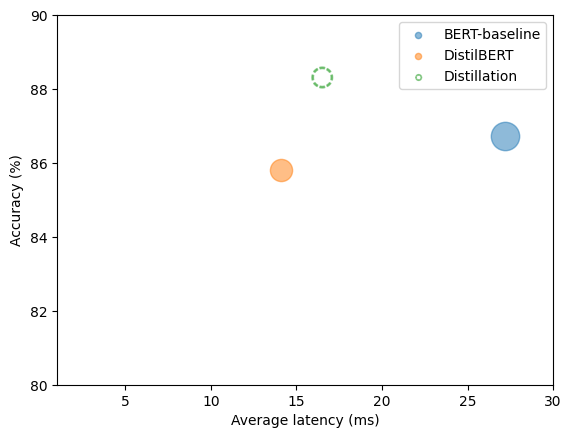

In [61]:
plot_metrics(perf_metrics, optim_type)

The model size and latency remain essentially unchanged compared to DistilBERT benchmark, but the accuracy has improved and even surpassed the performance of the teacher!!!
One way to interpret this, is that the teacher has likely no tbeen fine-tuned as systematically as the student.

This is great, but we can actually compress our distilled model even further using a technique known as quantization.

## Making Models Faster with Quantization



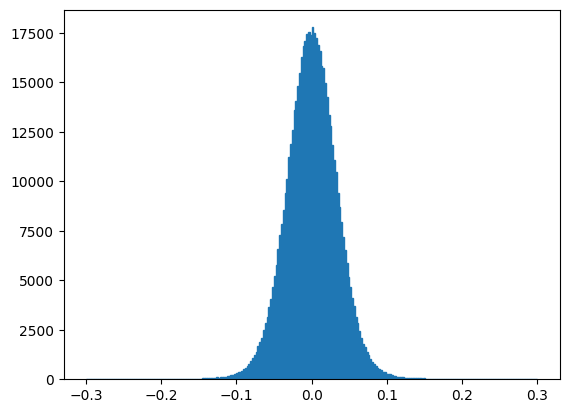

In [36]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().cpu().numpy(), bins=250, range=(-0.3, 0.3), edgecolor="C0")
plt.show()

In [37]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

to obtain the quantized tensor, we just need to invert the mapping $q = f/s + Z$, clamp de values, round them to the nearest integer, and represent the result in the *torch.int8* data type using the Tensor.char()

In [38]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   2,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   5,  ...,   0,   6,  -4],
        ...,
        [  6,   0,  13,  ...,   0,   6,  -1],
        [  1,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -1]], device='cuda:0',
       dtype=torch.int8)

In [39]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   2,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   5,  ...,   0,   6,  -4],
        ...,
        [  6,   0,  13,  ...,   0,   6,  -1],
        [  1,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -1]], device='cuda:0',
       dtype=torch.int8)

In [40]:
# For the quanitzed tensors we need the QFunctional wrapper class
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [41]:
q_fn.mul(quantized_weights.cpu(), quantized_weights.cpu())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], size=(768, 768), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=1.0, zero_point=0)

In [42]:
import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

3.999755879241598

Implementing dynamic quantization in PyTorch is quite simple and can be done with a single line of code

In [65]:
from torch.quantization import quantize_dynamic

model_ckpt = "sergi24sanchez/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt).to("cpu"))

model_quanitzed = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

## Benchmarking Out Quantized Model

In [66]:
pipe = pipeline("text-classification", model=model_quanitzed, tokenizer=tokenizer, device=-1) # force cpu
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.39
Average latency (ms) - 4.49 +\- 0.16
Accuracy on test set - 0.895


/tmp/ipykernel_1523099/3513452108.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


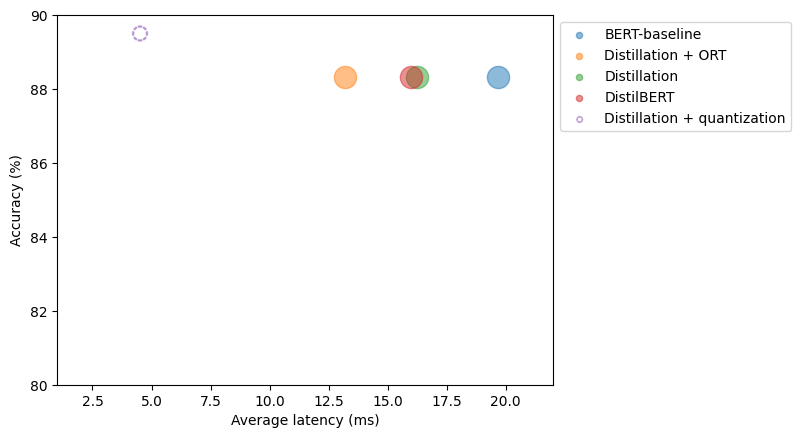

In [52]:
plot_metrics(perf_metrics, optim_type)

Incredible!!! The quantized model is almost half the size of our distilled one and has even gained a slight accuracy boost.

## Optimization Inference with ONNX and the ONNX Runtime

ONNX is an open standard that defines a common set of operators and a common file format to represent deep learning models in a wide variety of frameworks, including Pytorch.
When a model is exported to the ONNX format, these operators are used to construct a computational graph that represents the flow of data through the neural network.
By exposing a graph with standardized operators and data types, ONNX makes it esasy to switch between frameworks.

Where ONNX shines is when it is coupled with a dedicated accelarator like **ONNX Runtime**. ORT provides tools to optimize the graph through techniques like operator fusion and constant folding, and defines an interface to *execution providers* that allow you to run the model on different types of hardware. This is a powerful abstraction.

The first thing we need to do is convert our distilled model into the ONNX format. *convert_graph_to_onnx.convert()* simplifies the process by taking the following steps:
1. Initialize the model as a *Pipeline*
2. Run placeholder inputs through the pipeline so that ONNX can record the computational graph.
3. Define dynamic axes to handle dynamic sequence lengths.
4. Save the graph with network parameters.

We first need to set some **OpenMP** environment variables for ONNX:

In [2]:
import os
from psutil import cpu_count
from pathlib import Path

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

OpenMP is an API designed for developing highly parallelized applications.

Next, let's convert our distilled model to the ONNX format. We need to specify the argument *pipeline_name='text-classification'* since *convert()* wraps the model in tranformers pipeline().

In [67]:
from transformers.convert_graph_to_onnx import convert

model_ckpt = "sergi24sanchez/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework='pt', model=model_ckpt, tokenizer=tokenizer, output=onnx_model_path, opset=12, pipeline_name="text-classification") # opset corresponds to a specific version of the ONNX library

/home/ssanchez/env/transformers/lib/python3.8/site-packages/transformers/convert_graph_to_onnx.py:361: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


ONNX opset version set to: 12
Loading pipeline (model: sergi24sanchez/distilbert-base-uncased-distilled-clinc, tokenizer: DistilBertTokenizerFast(name_or_path='sergi24sanchez/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=Fal

Exception: Folder onnx is not empty, aborting conversion

Now that we have our model saves, we need to create an InferenceSession instance to feed inputs to the model:

In [68]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession, SessionOptions)

def create_model_for_provider(model_path,
                             provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

onnx_model = create_model_for_provider(onnx_model_path)

Now when we call onnx_model.run(), we can get the class logits from the ONNX model. Let's test this out with an example from the test set.
Since the output from convert() tells us that ONNX expects just the *input_ids* and *attention_mask* as inputs, we need to drop the *label* column from our sample:

In [37]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [38]:
# Once we have the logits, we can easily get the predicted label by taking the argmax
np.argmax(logits_onnx)

61

In [40]:
# agrees with the ground truth label
clinc_enc["test"][0]["labels"]

61

The ONNX model is not compatible with the *text-classification* pipeline, so we'll create our own class that mimics the core behavior:

In [69]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                      for k,v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [70]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.91333336}]

Next step is to create a performance benchmark for ONNX models. Here we can build on the work we did with thr *PerformanceBenchmark*  by simply overriding the *compute_size()* and leaving the *compute_accuracy()* and *time_pipeline()* intact.
We need to override compute_size() since we cannot rely on the *state_dict* and *torch.save()* to measure a model's size, since *onnx_model* is technically an ONNX *InferenceSession* object that doesn't have acces to the attributes of PyTorch's nn.Module

In [71]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [72]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.98
Average latency (ms) - 12.89 +\- 0.17
Accuracy on test set - 0.883


/tmp/ipykernel_1523099/3513452108.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


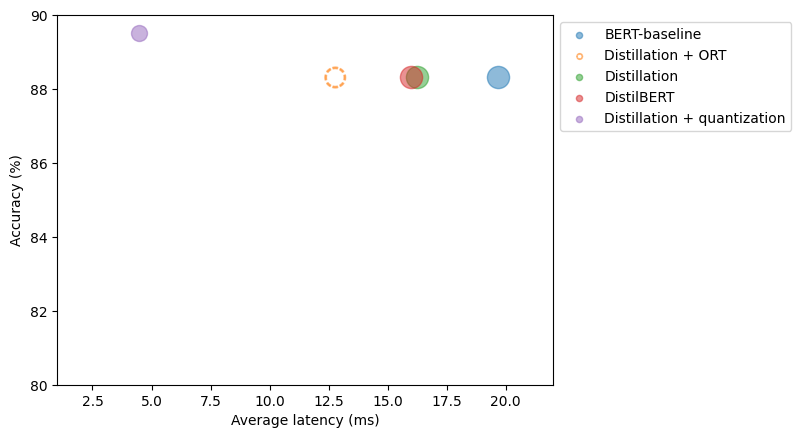

In [59]:
plot_metrics(perf_metrics, optim_type)

ORT offers three ways to quantize a model: dynamic, static, and quantization-aware training.
The quantization is applied through the *quantize_dynamic()* function, which requires a path to the ONNX model to quanitze, a target path to save the quantized model to, and the data type to reduce the weights to:

In [60]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

In [73]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 64.36
Average latency (ms) - 8.98 +\- 0.03
Accuracy on test set - 0.892


/tmp/ipykernel_1523099/3513452108.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


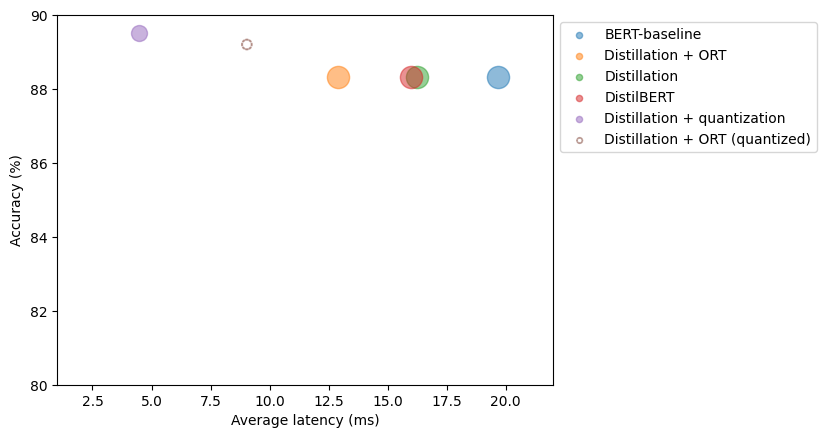

In [74]:
plot_metrics(perf_metrics, optim_type)

ORT quantization has reduced the model size and latency by around 30% compared to the model from PyTorch quantization(distillation+quantization).
Pytorch only optimizes the nn.Linear modules, while ONNX quantized the embedding layer as well.

From the plot we can also see that applying ORT quantization to our distilled model has provided an almost three-fold gain compared to our BERT baseline!

Another strategy to reduce the size is to remove some weights altogether. This technique is called *weight pruning*.

## Making Models Sparser with Weight Pruning